In [38]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer

In [39]:
data = pd.read_csv('departures_for_model.csv')

In [40]:
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed


In [43]:
# Combine 'date_depart' and 'departure_time_scheduled' into a single column
data['departure_datetime'] = data['date_depart'] + ' ' + data['departure_time_scheduled']
data['departure_datetime'] = pd.to_datetime(data['departure_datetime'], format='%Y-%m-%d %H:%M:%S')


In [44]:
data['date_depart'] = pd.to_datetime(data['date_depart'], format='%Y-%m-%d')


In [45]:
# Define the function to categorize times into the four bins
def time_of_day_category(departure_time):
    if 5 <= departure_time.hour < 9:
        return 1  # Morning (5 AM - 10 PM)
    elif 9 <= departure_time.hour < 13:
        return 2  # Noon (10 PM - 3 PM)
    elif 13 <= departure_time.hour < 18:
        return 3  # Day (3 PM - 7 PM)
    else:
        return 4  # Evening/Night (6 PM - 5 AM)

# Apply the function to the 'departure_datetime' column to create the new column
data['time_of_day_bin'] = data['departure_datetime'].apply(time_of_day_category)


/var/folders/0x/0vrn4bsj03q36gqflgz3f1sh0000gp/T/ipykernel_49735/3948359474.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_of_day_bin', y='departure_time_difference', data=time_of_day_sum, palette='viridis')


Text(0.5, 1.0, 'Sum of Departure Time Difference by Time of Day Bins')

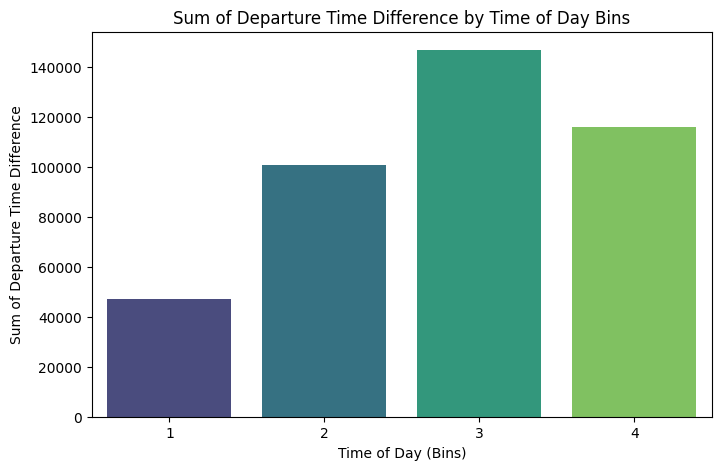

In [47]:
time_of_day_sum = data.groupby('time_of_day_bin')['departure_time_difference'].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='time_of_day_bin', y='departure_time_difference', data=time_of_day_sum, palette='viridis')

# Add labels and title
plt.xlabel('Time of Day (Bins)')
plt.ylabel('Sum of Departure Time Difference')
plt.title('Sum of Departure Time Difference by Time of Day Bins')

In [48]:
def extract_time_features(df, date_column):
    df = df.copy()
    df['day'] = pd.to_datetime(df[date_column]).dt.day
    return df

In [49]:
data = extract_time_features(data, 'date_depart')
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status,departure_datetime,time_of_day_bin,day
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed,2024-09-02 06:00:00,1,2
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed,2024-09-02 06:00:00,1,2
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed,2024-09-02 06:15:00,1,2
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed,2024-09-02 06:15:00,1,2
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed,2024-09-02 06:15:00,1,2


In [12]:
average_departure_time_difference = data.groupby('airline')['departure_time_difference'].mean().reset_index()

# Rename the column for clarity
average_departure_time_difference.columns = ['airline', 'average_departure_time_difference']

# Display the result
average_departure_time_difference

,airline,average_departure_time_difference
0,Aegean Airlines,28.619048
1,Aer Lingus,31.160156
2,Aero Services Executive,11.656250
3,Aeromexico,19.333333
4,Air Albania,38.000000
...,...,...
170,Wizz Air Hungary,89.555556
171,Wizz Air Malta,96.500000
172,Wizz Air Uk,33.666667
173,World2Fly Portugal,25.200000


In [17]:
data = pd.merge(data, average_departure_time_difference, on='airline', how='left')
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status,departure_datetime,time_of_day_bin,average_departure_time_difference
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed,2024-09-02 06:00:00,1,35.750000
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed,2024-09-02 06:00:00,1,42.252525
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed,2024-09-02 06:15:00,1,40.672490
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed,2024-09-02 06:15:00,1,21.954918
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed,2024-09-02 06:15:00,1,40.672490


In [27]:
avg_time_airline = data.groupby(['airline', 'time_of_day_bin'])['departure_time_difference'].mean().reset_index()

# Rename the column for clarity
avg_time_airline.rename(columns={'departure_time_difference': 'avg_time_airline'}, inplace=True)

# Display the result
avg_time_airline

,airline,time_of_day_bin,avg_time_airline
0,Aegean Airlines,2,26.341463
1,Aegean Airlines,3,32.600000
2,Aegean Airlines,4,28.931818
3,Aer Lingus,1,19.800000
4,Aer Lingus,2,29.263889
...,...,...,...
391,Wizz Air Uk,4,33.666667
392,World2Fly Portugal,2,31.000000
393,World2Fly Portugal,3,23.750000
394,Zimex Aviation,2,0.000000


In [28]:
data = pd.merge(data, avg_time_airline, 
                       on=['airline', 'time_of_day_bin'], 
                       how='left')

# Display the result
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status,departure_datetime,time_of_day_bin,average_departure_time_difference,destination_city_avg,average_difference_day_code,avg_time_airline
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed,2024-09-02 06:00:00,1,35.750000,15.584046,27.587576,14.666667
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed,2024-09-02 06:00:00,1,42.252525,23.267470,27.587576,29.848485
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed,2024-09-02 06:15:00,1,40.672490,16.314286,27.587576,26.402635
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed,2024-09-02 06:15:00,1,21.954918,40.008197,27.587576,11.882353
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed,2024-09-02 06:15:00,1,40.672490,29.770186,27.587576,26.402635


In [36]:
avg_day_airline = data.groupby(['airline', 'day'])['departure_time_difference'].mean().reset_index()

# Rename the column for clarity
avg_day_airline.rename(columns={'departure_time_difference': 'avg_day_airline'}, inplace=True)

# Display the result
avg_day_airline

,airline,day,avg_day_airline
0,Aegean Airlines,1,0.0
1,Aegean Airlines,2,25.5
2,Aegean Airlines,3,30.2
3,Aegean Airlines,4,39.0
4,Aegean Airlines,5,50.0
...,...,...,...
1780,World2Fly Portugal,9,20.0
1781,World2Fly Portugal,10,31.0
1782,World2Fly Portugal,11,31.0
1783,Zimex Aviation,7,0.0


In [37]:
data = pd.merge(data, avg_day_airline, 
                       on=['airline', 'day'], 
                       how='left')

# Display the result
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status,departure_datetime,time_of_day_bin,average_departure_time_difference,destination_city_avg,average_difference_day_code,avg_time_airline,day,avg_day_airline
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed,2024-09-02 06:00:00,1,35.750000,15.584046,27.587576,14.666667,2,18.500000
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed,2024-09-02 06:00:00,1,42.252525,23.267470,27.587576,29.848485,2,41.000000
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed,2024-09-02 06:15:00,1,40.672490,16.314286,27.587576,26.402635,2,41.000000
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed,2024-09-02 06:15:00,1,21.954918,40.008197,27.587576,11.882353,2,19.230769
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed,2024-09-02 06:15:00,1,40.672490,29.770186,27.587576,26.402635,2,41.000000


In [27]:
avg_day_airport = data.groupby(['departure_city', 'day'])['departure_time_difference'].mean().reset_index()

# Rename the column for clarity
avg_day_airport.rename(columns={'departure_time_difference': 'avg_day_airport'}, inplace=True)

# Display the result
avg_day_airport.head()

,departure_city,day,avg_day_airport
0,Berlin,1,15.393130
1,Berlin,2,11.864754
2,Berlin,3,7.428016
3,Berlin,4,10.000000
4,Berlin,5,10.114943


In [17]:
data = pd.merge(data, avg_day_airport, 
                       on=['departure_city', 'day'], 
                       how='left')

# Display the result
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status,departure_datetime,time_of_day_bin,day,avg_day_airport
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed,2024-09-02 06:00:00,1,2,38.76227
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed,2024-09-02 06:00:00,1,2,38.76227
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed,2024-09-02 06:15:00,1,2,38.76227
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed,2024-09-02 06:15:00,1,2,38.76227
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed,2024-09-02 06:15:00,1,2,38.76227


In [44]:
avg_day_destination = data.groupby(['destination_city', 'day'])['departure_time_difference'].mean().reset_index()

# Rename the column for clarity
avg_day_destination.rename(columns={'departure_time_difference': 'avg_day_destination'}, inplace=True)

# Display the result
avg_day_destination

,destination_city,day,avg_day_destination
0,Aalborg,10,17.000000
1,Aberdeen,2,44.000000
2,Aberdeen,3,24.250000
3,Aberdeen,4,23.666667
4,Aberdeen,5,54.125000
...,...,...,...
3886,Zurich,25,12.000000
3887,Zurich,26,19.090909
3888,Zurich,27,5.000000
3889,Zurich,28,34.416667


In [45]:
data = pd.merge(data, avg_day_destination, 
                       on=['destination_city', 'day'], 
                       how='left')

# Display the result
data.head()

,airline,departure_time_scheduled,date_depart,departure_city,destination_city,country,departure_time_difference,departure_status,departure_datetime,time_of_day_bin,average_departure_time_difference,destination_city_avg,average_difference_day_code,avg_time_airline,day,avg_day_airline,avg_day_airport,avg_day_destination
0,Austrian,06:00:00,2024-09-02,London,Vienna,Austria,11,Delayed,2024-09-02 06:00:00,1,35.750000,15.584046,27.587576,14.666667,2,18.500000,38.76227,18.875000
1,Swiss International Airlines,06:00:00,2024-09-02,London,Zurich,Switzerland,6,Delayed,2024-09-02 06:00:00,1,42.252525,23.267470,27.587576,29.848485,2,41.000000,38.76227,27.700000
2,British Airways,06:15:00,2024-09-02,London,Malaga,Spain,11,Delayed,2024-09-02 06:15:00,1,40.672490,16.314286,27.587576,26.402635,2,41.000000,38.76227,7.000000
3,Air France,06:15:00,2024-09-02,London,Paris,France,6,Delayed,2024-09-02 06:15:00,1,21.954918,40.008197,27.587576,11.882353,2,19.230769,38.76227,32.692308
4,British Airways,06:15:00,2024-09-02,London,Edinburgh,United Kingdom,13,Delayed,2024-09-02 06:15:00,1,40.672490,29.770186,27.587576,26.402635,2,41.000000,38.76227,43.916667


/var/folders/0x/0vrn4bsj03q36gqflgz3f1sh0000gp/T/ipykernel_49735/4003524514.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day', y='departure_time_difference', data=date_of_day_sum, palette='viridis')


Text(0.5, 1.0, 'Sum of Departure Time Difference by Day')

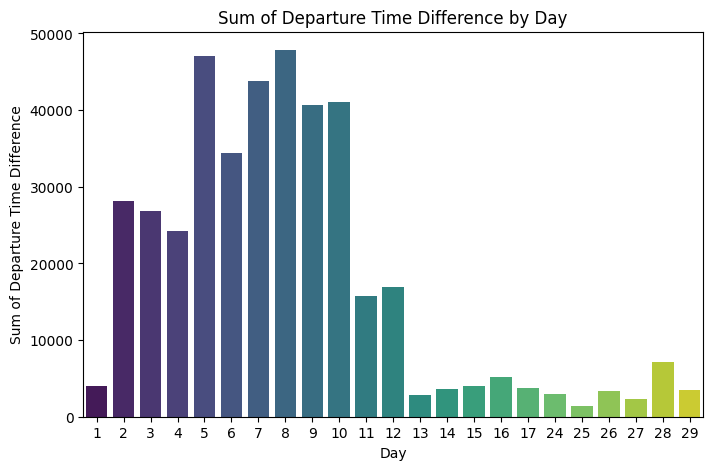

In [20]:
date_of_day_sum = data.groupby('day')['departure_time_difference'].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='day', y='departure_time_difference', data=date_of_day_sum, palette='viridis')

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Sum of Departure Time Difference')
plt.title('Sum of Departure Time Difference by Day')

In [52]:
average_departure_time_difference = data[['airline', 'average_departure_time_difference']].drop_duplicates()
average_departure_time_difference

,airline,average_departure_time_difference
0,Austrian,35.750000
1,Swiss International Airlines,42.252525
2,British Airways,40.672490
3,Air France,21.954918
6,Klm - Royal Dutch Airlines,40.573529
...,...,...
14329,Jet2.Com,43.000000
14343,Jettime A/S,17.000000
14495,Neos,94.000000
14507,Israir Airlines,72.000000


In [53]:
avg_time_airline = data[['airline', 'time_of_day_bin', 'avg_time_airline']].drop_duplicates()
avg_time_airline

,airline,time_of_day_bin,avg_time_airline
0,Austrian,1,14.666667
1,Swiss International Airlines,1,29.848485
2,British Airways,1,26.402635
3,Air France,1,11.882353
6,Klm - Royal Dutch Airlines,1,39.388889
...,...,...,...
14495,Neos,4,94.000000
14507,Israir Airlines,4,72.000000
14510,Ryanair Uk,4,75.000000
15129,Norwegian Air Sweden,4,40.000000


In [54]:
avg_day_airline = data[['airline', 'day', 'avg_day_airline']].drop_duplicates()
avg_day_airline

,airline,day,avg_day_airline
0,Austrian,2,18.500000
1,Swiss International Airlines,2,41.000000
2,British Airways,2,41.000000
3,Air France,2,19.230769
6,Klm - Royal Dutch Airlines,2,48.500000
...,...,...,...
15141,Lam,12,69.000000
15164,Wizz Air Uk,12,37.000000
15173,El Al,12,42.000000
15179,Egyptair,13,68.000000


In [37]:
avg_day_airport = data[['departure_city', 'day', 'avg_day_airport']].drop_duplicates()
avg_day_airport

,departure_city,day,avg_day_airport
0,London,2,38.762270
652,London,3,36.098266
1344,London,4,35.040521
2035,London,5,64.314493
2725,London,6,44.458027
3404,London,7,40.611198
4047,London,8,46.570762
4690,London,9,35.897210
5371,London,10,39.046338
6040,Berlin,1,15.393130


In [55]:
avg_day_destination = data[['destination_city', 'day', 'avg_day_destination']].drop_duplicates()
avg_day_destination

,destination_city,day,avg_day_destination
0,Vienna,2,18.875000
1,Zurich,2,27.700000
2,Malaga,2,7.000000
3,Paris,2,32.692308
4,Edinburgh,2,43.916667
...,...,...,...
15184,"São Paulo, Guarulhos",13,35.000000
15185,Nador,13,17.000000
15186,Recife,13,20.000000
15188,Madeira,13,41.000000


In [56]:
average_departure_time_difference.to_csv('features_departures/average_departure_time_difference.csv', index=False)
avg_time_airline.to_csv('features_departures/avg_time_airline.csv', index=False)
avg_day_airline.to_csv('features_departures/avg_day_airline.csv', index=False)
avg_day_destination.to_csv('features_departures/avg_day_destination.csv', index=False)
avg_day_airport.to_csv('features_departures/avg_day_airport.csv', index=False)

In [50]:
average_departure_time_difference = pd.read_csv('features_departures/average_departure_time_difference.csv')
avg_day_airline = pd.read_csv('features_departures/avg_day_airline.csv')
avg_day_destination = pd.read_csv('features_departures/avg_day_destination.csv')
avg_time_airline = pd.read_csv('features_departures/avg_time_airline.csv')
avg_day_airport = pd.read_csv('features_departures/avg_day_airport.csv')

data = pd.merge(data, avg_day_destination, 
                       on=['destination_city', 'day'], 
                       how='left')

data = pd.merge(data, avg_time_airline, 
                       on=['airline', 'time_of_day_bin'], 
                       how='left')

data = pd.merge(data, avg_day_airline, 
                       on=['airline', 'day'], 
                       how='left')

data = pd.merge(data, avg_day_airport, 
                       on=['departure_city', 'day'], 
                       how='left')

data = pd.merge(data, average_departure_time_difference, on='airline', how='left')

In [51]:
# Select features and target
X = data[['airline', 'departure_city', 'destination_city', 'average_departure_time_difference', 'avg_time_airline', 'avg_day_airline', 'avg_day_destination', 'avg_day_airport']]
y = data['departure_time_difference']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up preprocessing for categorical and numerical columns
categorical_cols = ['airline', 'departure_city', 'destination_city']
numerical_cols = ['average_departure_time_difference', 'avg_time_airline', 'avg_day_airline', 'avg_day_destination', 'avg_day_airport']

# Use ColumnTransformer to apply imputation and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))
        ]), numerical_cols),  # Impute numerical features
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute categorical features
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='passthrough'  # Ensure that the numerical features are not modified
)

# Build a pipeline with preprocessor and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R² Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 15.387803267832714
R² Score: 0.4096073885479611
